# This is the data analysis

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pydicom
import pandas as pd
from glob import glob
import os
from matplotlib.patches import Rectangle
base_path = '/media/snet/data/TEST18/'
det_class_path = base_path + 'stage_1_detailed_class_info.csv'
bbox_path = base_path + 'stage_1_train_labels.csv'
dicom_dir = base_path + 'stage_1_train_images/'

28989 class infos loaded
25684 patient cases


,patientId,class
15338,960131aa-4ce4-4b26-aa12-5f73d8d81453,Normal
7017,5393a822-0a9d-42c6-a5d8-221cb5ac25d3,No Lung Opacity / Not Normal
14865,92146ef9-15ba-48b9-ad5a-893a27c6f484,Lung Opacity


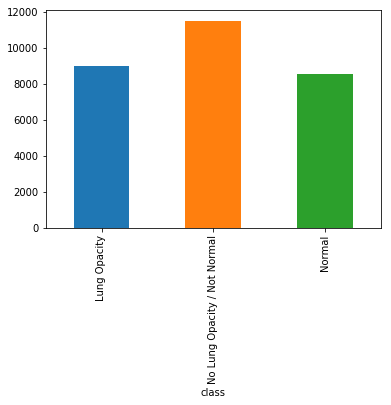

In [4]:
det_class_df = pd.read_csv(det_class_path)
print(det_class_df.shape[0], 'class infos loaded')
print(det_class_df['patientId'].value_counts().shape[0], 'patient cases')
det_class_df.groupby('class').size().plot.bar()
det_class_df.sample(3)

In [5]:
bbox_df = pd.read_csv(bbox_path)
print(bbox_df.shape[0], 'boxes loaded')
print(bbox_df['patientId'].value_counts().shape[0], 'patient cases')
bbox_df.sample(3)

28989 boxes loaded
25684 patient cases


,patientId,x,y,width,height,Target
28682,fdaaedbe-1d47-4626-a7ab-f9f06dfd009a,NaN,NaN,NaN,NaN,0
17116,a449d778-47a8-4edf-a90e-11edbb62ab16,NaN,NaN,NaN,NaN,0
6281,4dbc44ca-694a-4814-9a24-bc60c8d8d611,224.0,155.0,286.0,435.0,1


In [6]:
comb_bbox_df = pd.concat([bbox_df, 
                        det_class_df.drop('patientId',1)], 1)
print(comb_bbox_df.shape[0], 'combined cases')
comb_bbox_df.sample(3)


28989 combined cases


,patientId,x,y,width,height,Target,class
19624,b5b76ad2-a31e-4590-88bf-a71507e3df5e,NaN,NaN,NaN,NaN,0,Normal
6041,4b9f808b-2e83-455f-9afb-dab90444055e,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
15496,976683bf-4b41-4641-8763-cb2613a2aba1,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal


In [8]:


box_df = comb_bbox_df.groupby('patientId').\
    size().\
    reset_index(name='boxes')
comb_box_df = pd.merge(comb_bbox_df, box_df, on='patientId')
box_df.\
    groupby('boxes').\
    size().\
    reset_index(name='patients')



,boxes,patients
0,1,22506
1,2,3062
2,3,105
3,4,11


### the important point here is that we have up to FOUR boxes in a single study.
### therefore variable DETECTION_MAX_INSTANCES = 4 


In [9]:
comb_bbox_df.groupby(['class', 'Target']).size().reset_index(name='Patient Count')

,class,Target,Patient Count
0,Lung Opacity,1,8964
1,No Lung Opacity / Not Normal,0,11500
2,Normal,0,8525


In [10]:
image_df = pd.DataFrame({'path': glob(os.path.join(dicom_dir, '*.dcm'))})
image_df['patientId'] = image_df['path'].map(lambda x: os.path.splitext(os.path.basename(x))[0])
print(image_df.shape[0], 'images found')
img_pat_ids = set(image_df['patientId'].values.tolist())
box_pat_ids = set(comb_box_df['patientId'].values.tolist())
# check to make sure there is no funny business
assert img_pat_ids.union(box_pat_ids)==img_pat_ids, "Patient IDs should be the same"

25684 images found


,BodyPartExamined,PatientSex,ViewPosition
count,25684,25684,25684
unique,1,2,2
top,CHEST,M,PA
freq,25684,14593,13979


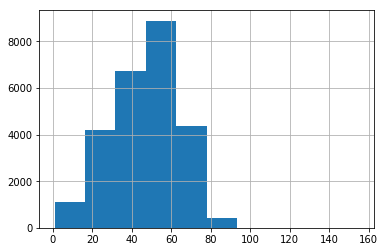

In [11]:
DCM_TAG_LIST = ['PatientAge', 'BodyPartExamined', 'ViewPosition', 'PatientSex']
def get_tags(in_path):
    c_dicom = pydicom.read_file(in_path, stop_before_pixels=True)
    tag_dict = {c_tag: getattr(c_dicom, c_tag, '') 
         for c_tag in DCM_TAG_LIST}
    tag_dict['path'] = in_path
    return pd.Series(tag_dict)
image_meta_df = image_df.apply(lambda x: get_tags(x['path']), 1)
# show the summary
image_meta_df['PatientAge'] = image_meta_df['PatientAge'].map(int)
image_meta_df['PatientAge'].hist()
image_meta_df.drop('path',1).describe(exclude=np.number)

In [12]:
image_full_df = pd.merge(image_df,
                         image_meta_df,
                         on='path')
image_bbox_df = pd.merge(comb_box_df, 
                         image_full_df, 
                         on='patientId',
                        how='left')
print(image_bbox_df.shape[0], 'image bounding boxes')
image_bbox_df.sample(3)

28989 image bounding boxes


,patientId,x,y,width,height,Target,class,boxes,path,BodyPartExamined,PatientAge,PatientSex,ViewPosition
22242,c9508c43-8f00-472f-ba57-c5a249d6cf59,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,1,/media/snet/data/TEST18/stage_1_train_images/c...,CHEST,50,F,PA
13013,838d5522-d44f-49a5-a4e2-7e84a75c2f75,NaN,NaN,NaN,NaN,0,Normal,1,/media/snet/data/TEST18/stage_1_train_images/8...,CHEST,59,M,PA
7508,579c68e7-c03e-4cd7-bda5-93de372571f2,NaN,NaN,NaN,NaN,0,Normal,1,/media/snet/data/TEST18/stage_1_train_images/5...,CHEST,21,M,PA


In [13]:
sample_df = image_bbox_df.\
    groupby(['Target','class', 'boxes']).\
    apply(lambda x: x[x['patientId']==x.sample(1)['patientId'].values[0]]).\
    reset_index(drop=True)
sample_df


,patientId,x,y,width,height,Target,class,boxes,path,BodyPartExamined,PatientAge,PatientSex,ViewPosition
0,e99f5aba-4cd8-45db-a096-b051326af2e5,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,1,/media/snet/data/TEST18/stage_1_train_images/e...,CHEST,20,M,AP
1,c90cbfe6-d98f-407b-b3c2-45b27fd1ae72,NaN,NaN,NaN,NaN,0,Normal,1,/media/snet/data/TEST18/stage_1_train_images/c...,CHEST,65,M,PA
2,bf4649af-b05d-4b63-8b6c-dfac44e5750b,661.0,322.0,164.0,302.0,1,Lung Opacity,1,/media/snet/data/TEST18/stage_1_train_images/b...,CHEST,49,F,PA
3,a41249dd-3195-4d4d-bcaa-7ea2178e2d68,588.0,341.0,256.0,419.0,1,Lung Opacity,2,/media/snet/data/TEST18/stage_1_train_images/a...,CHEST,31,M,AP
4,a41249dd-3195-4d4d-bcaa-7ea2178e2d68,153.0,204.0,262.0,546.0,1,Lung Opacity,2,/media/snet/data/TEST18/stage_1_train_images/a...,CHEST,31,M,AP
5,759a11de-da95-4cb8-a373-ab848ae74171,713.0,514.0,208.0,256.0,1,Lung Opacity,3,/media/snet/data/TEST18/stage_1_train_images/7...,CHEST,54,F,AP
6,759a11de-da95-4cb8-a373-ab848ae74171,344.0,266.0,204.0,474.0,1,Lung Opacity,3,/media/snet/data/TEST18/stage_1_train_images/7...,CHEST,54,F,AP
7,759a11de-da95-4cb8-a373-ab848ae74171,729.0,269.0,145.0,190.0,1,Lung Opacity,3,/media/snet/data/TEST18/stage_1_train_images/7...,CHEST,54,F,AP
8,32408669-c137-4e8d-bd62-fe8345b40e73,273.0,856.0,234.0,101.0,1,Lung Opacity,4,/media/snet/data/TEST18/stage_1_train_images/3...,CHEST,46,M,AP
9,32408669-c137-4e8d-bd62-fe8345b40e73,702.0,801.0,249.0,144.0,1,Lung Opacity,4,/media/snet/data/TEST18/stage_1_train_images/3...,CHEST,46,M,AP


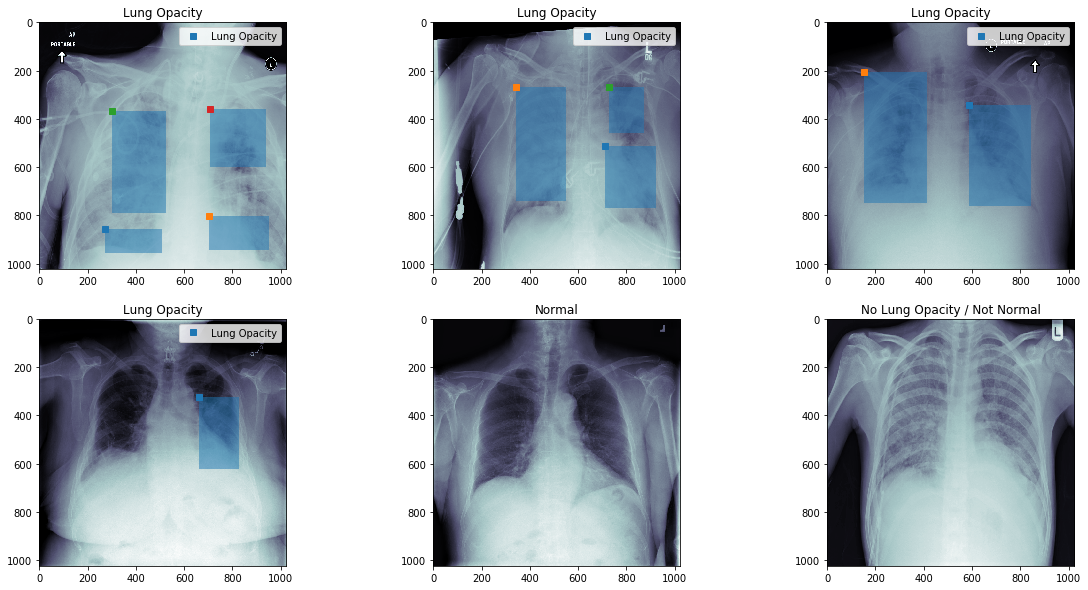

In [14]:
fig, m_axs = plt.subplots(2, 3, figsize = (20, 10))
for c_ax, (c_path, c_rows) in zip(m_axs.flatten(),
                    sample_df.groupby(['path'])):
    c_dicom = pydicom.read_file(c_path)
    c_ax.imshow(c_dicom.pixel_array, cmap='bone')
    c_ax.set_title('{class}'.format(**c_rows.iloc[0,:]))
    for i, (_, c_row) in enumerate(c_rows.dropna().iterrows()):
        c_ax.plot(c_row['x'], c_row['y'], 's', label='{class}'.format(**c_row))
        c_ax.add_patch(Rectangle(xy=(c_row['x'], c_row['y']),
                                width=c_row['width'],
                                height=c_row['height'], 
                                 alpha = 0.5))
        if i==0: c_ax.legend()



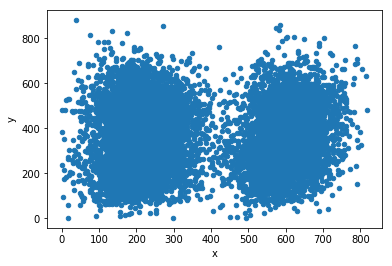

In [15]:
pos_bbox = image_bbox_df.query('Target==1')
pos_bbox.plot.scatter(x='x', y='y')

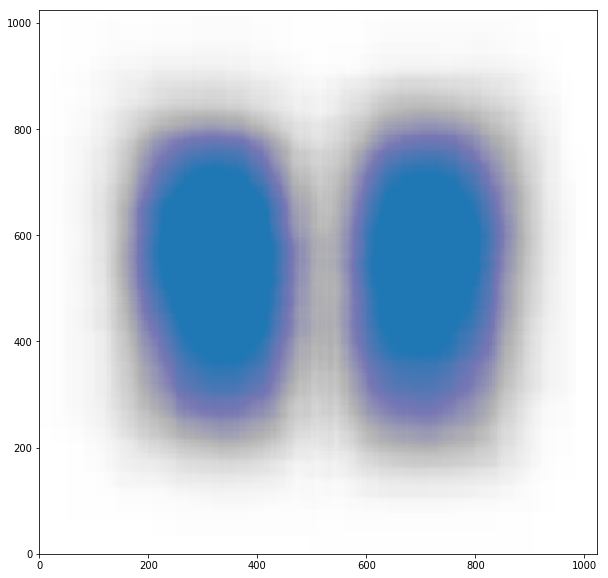

In [16]:
fig, ax1 = plt.subplots(1, 1, figsize = (10, 10))
ax1.set_xlim(0, 1024)
ax1.set_ylim(0, 1024)
for _, c_row in pos_bbox.sample(1000).iterrows():
    ax1.add_patch(Rectangle(xy=(c_row['x'], c_row['y']),
                 width=c_row['width'],
                 height=c_row['height'],
                           alpha=5e-3))

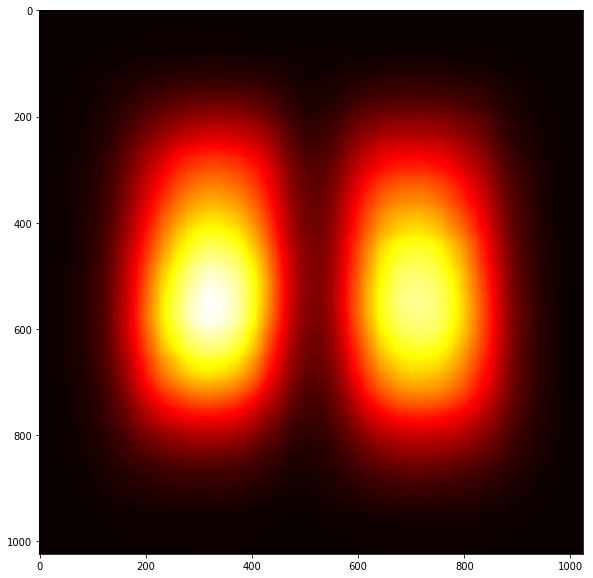

In [17]:
# Show the boxes themselves
X_STEPS, Y_STEPS = 1024, 1024
xx, yy = np.meshgrid(np.linspace(0, 1024, X_STEPS),
           np.linspace(0, 1024, Y_STEPS), 
           indexing='xy')
prob_image = np.zeros_like(xx)
for _, c_row in pos_bbox.sample(5000).iterrows():
    c_mask = (xx>=c_row['x']) & (xx<=(c_row['x']+c_row['width']))
    c_mask &= (yy>=c_row['y']) & (yy<=c_row['y']+c_row['height'])
    prob_image += c_mask
fig, ax1 = plt.subplots(1, 1, figsize = (10, 10))
ax1.imshow(prob_image, cmap='hot')

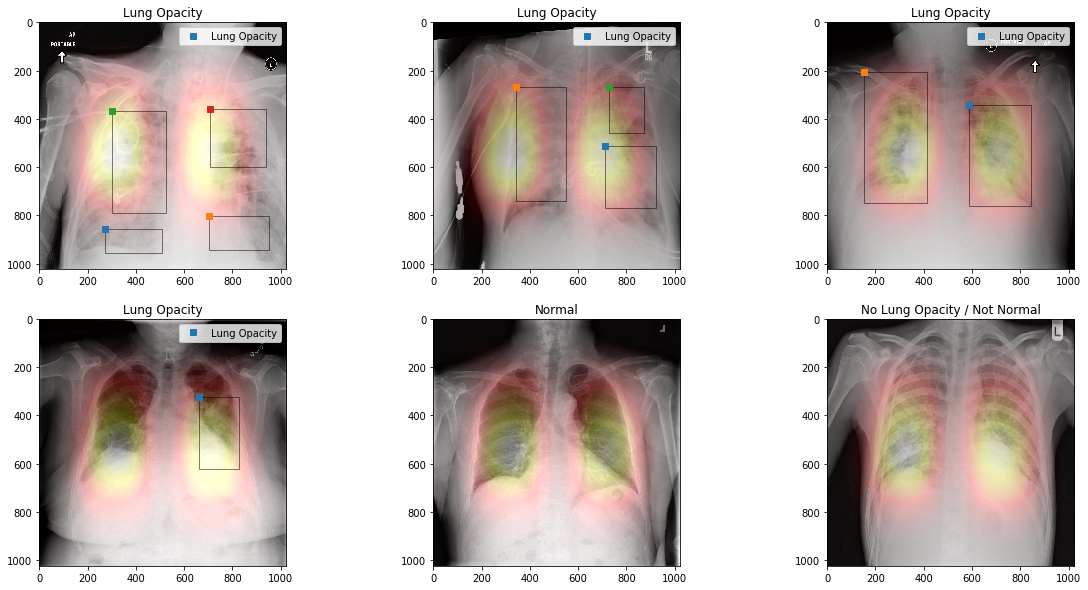

In [18]:
fig, m_axs = plt.subplots(2, 3, figsize = (20, 10))
for c_ax, (c_path, c_rows) in zip(m_axs.flatten(),
                    sample_df.groupby(['path'])):
    c_img_arr = pydicom.read_file(c_path).pixel_array
    # overlay
    c_img = plt.cm.gray(c_img_arr)
    c_img += 0.25*plt.cm.hot(prob_image/prob_image.max())
    c_img = np.clip(c_img, 0, 1)
    c_ax.imshow(c_img)
    
    c_ax.set_title('{class}'.format(**c_rows.iloc[0,:]))
    for i, (_, c_row) in enumerate(c_rows.dropna().iterrows()):
        c_ax.plot(c_row['x'], c_row['y'], 's', label='{class}'.format(**c_row))
        c_ax.add_patch(Rectangle(xy=(c_row['x'], c_row['y']),
                                width=c_row['width'],
                                height=c_row['height'], 
                                 alpha = 0.5,
                                fill=False))
        if i==0: c_ax.legend()
fig.savefig('overview.png', figdpi = 600)



In [19]:


image_bbox_df.to_csv('image_bbox_full.csv', index=False)

